In [ ]:
%pip install pytorch_lightning

# Importing required libraires





In [1]:
# pytorch packages
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger

# general packages
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

/opt/miniconda3/envs/dl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Downloading the dataset for MLP neural networks

In [2]:
url = "https://www.dropbox.com/scl/fi/wxc1jz8spd0thbzi4oj3h/mlp_data2.csv?rlkey=p0a22wgqlxdnxm7pum27lh86y&st=jelhn8kg&dl=1"

filename = "MLP.csv"

response = requests.get(url)

# Save the file locally
with open(filename, 'wb') as file:
    file.write(response.content)

# Looking into the dataset functions



## looking into the dataframe's columns distribution

In [3]:
def plot_data_hist(df, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    # Drop excluded columns
    columns = [col for col in df.columns if col not in exclude_columns]

    n_cols = 3
    n_rows = int(np.ceil(len(columns) / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), dpi=80)
    axs = axs.ravel()

    for i, col in enumerate(columns):
        axs[i].hist(df[col].dropna(), bins=30)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('count')

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

## Summarizing columns

In [4]:
def summarize_columns(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            print(f'{col} | max: {df[col].max()} | min: {df[col].min()}')
    print('len dataset:', len(df))

## Looking into the output variable historgram

In [5]:
def plot_hist_with_counts(df, column, bins=5):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    ax = df[column].plot.hist(bins=bins)

    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        bin_center = patch.get_x() + width / 2
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()

In [6]:
csv_file_path = filename  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)

print(df.columns)

Index(['Filename', 'Depth', 'Activations-Params', 'Activation Function',
       'Total Activations', 'Total Parameters', 'Batch Size',
       'Batch Normalization Layers', 'Dropout Layers', 'Max GPU Memory (MiB)',
       'Avg GPUTL', 'Avg GRACT', 'Avg SMACT', 'Avg SMOCC', 'Avg FP32A'],
      dtype='object')


# Changing the columns name for removing spaces from their names

In [7]:
df = df[['Max GPU Memory (MiB)',                                                                # output (target)
         'Depth', 'Activation Function', 'Batch Size', 'Batch Normalization Layers',            # input features
         'Dropout Layers', 'Total Parameters', 'Total Activations', 'Activations-Params', ]]

# Map the existing columns to your desired column structure
df = df.rename(columns={
    'Max GPU Memory (MiB)': 'real_memory_usage',        # target (output) variable
    # input variables
    'Depth': 'layers',                                  # number of linear layers
    'Batch Normalization Layers': 'batch_norm_layer',   # number of batch normalization layers
    'Dropout Layers': 'dropout_layers',                  # number dropout layers
    'Activation Function': 'activation_function',       # activation function, e.g., RELU, Tanh, ...
    'Batch Size': 'batch_size',                         # batch size
    'Total Parameters': 'all_parameters',               # all parameters in the network (weights + biases)
    'Total Activations': 'all_activations',             # all activation in the network (in MLP case: #neurons)
    'Activations-Params': 'params_neurons_list'        # the list showing the order of (layer type, activations, parameters)
})

df.head()

,real_memory_usage,layers,activation_function,batch_size,batch_norm_layer,dropout_layers,all_parameters,all_activations,params_neurons_list
0,1545,3,ReLU,996,2,2,3560152,7430,"[('linear', 1173, 2753031), ('batch_normalizat..."
1,1569,9,Softplus,939,0,8,3639009,13272,"[('linear', 936, 1754064), ('Softplus', 936, 0..."
2,1507,10,GELU,873,0,0,1207445,4596,"[('linear', 615, 757065), ('GELU', 615, 0), ('..."
3,1457,4,Mish,518,3,0,233316,1635,"[('linear', 295, 174640), ('batch_normalizatio..."
4,4505,11,SELU,983,0,0,140336299,74986,"[('linear', 3742, 14006306), ('SELU', 3742, 0)..."


# How the target variable is distributed over the dataset!

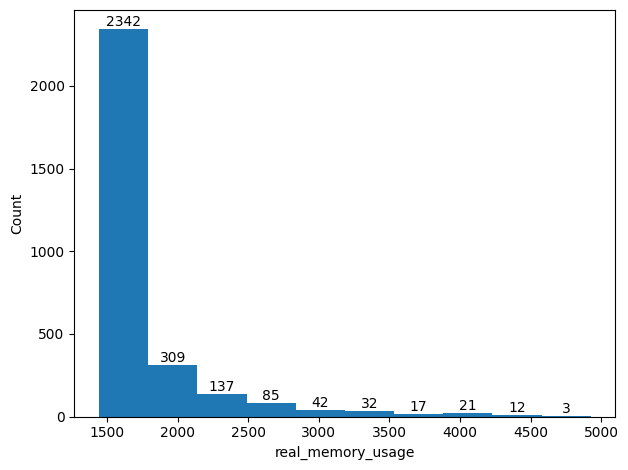

In [8]:
plot_hist_with_counts(df, 'real_memory_usage', 10)

# Looking into how input features are distributed

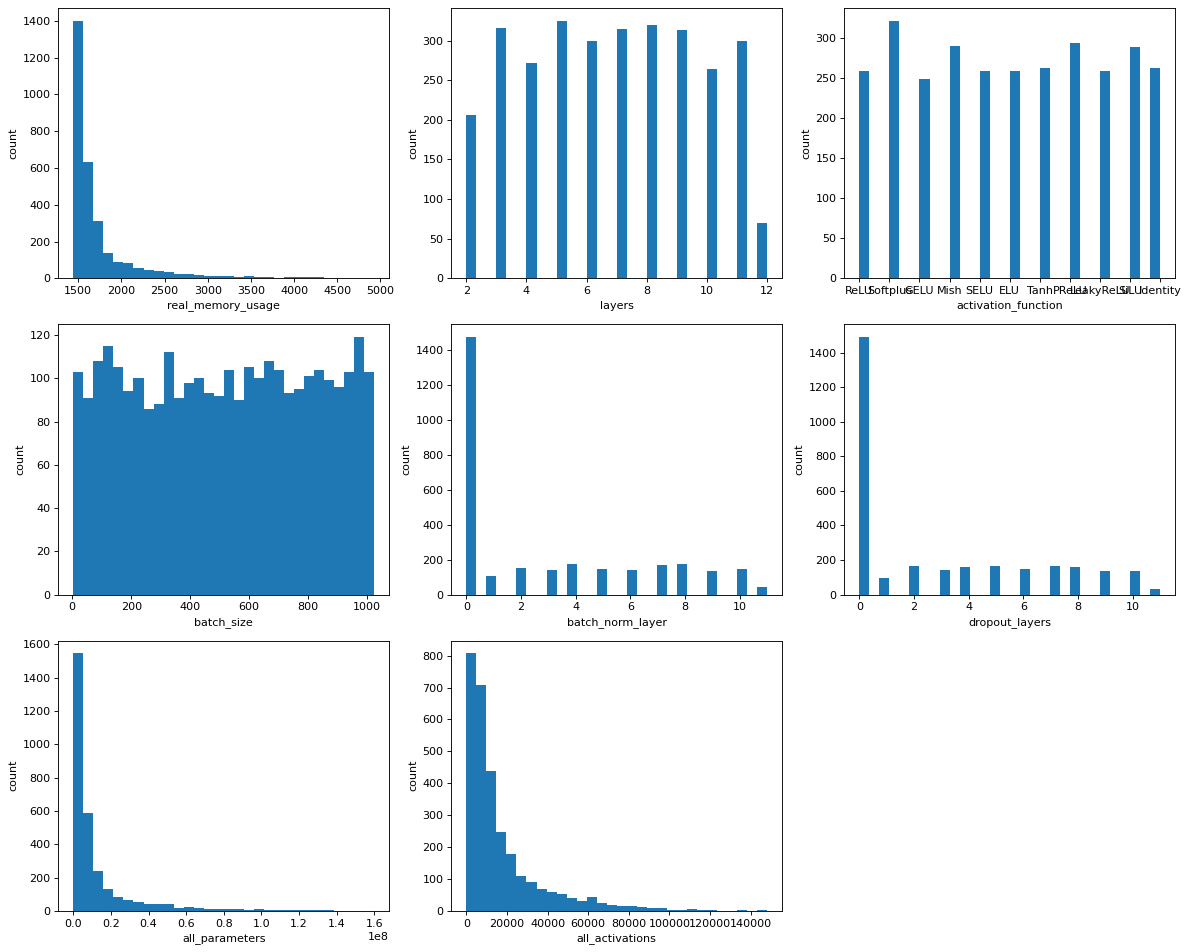

In [9]:
plot_data_hist(df, exclude_columns=['params_neurons_list'])

In [10]:
summarize_columns(df)

real_memory_usage | max: 4925 | min: 1443
layers | max: 12 | min: 2
batch_size | max: 1023 | min: 4
batch_norm_layer | max: 11 | min: 0
dropout_layers | max: 11 | min: 0
all_parameters | max: 159856482 | min: 27
all_activations | max: 148066 | min: 10
len dataset: 3000


# Positional Encoding for Activation Functions
## Activations function type as two separate input features

In [ ]:
# List of activation functions
activations = ['ELU', 'GELU', 'Identity', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['activation_function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['activation_function'].map(lambda x: activation_to_encoding[x][1])

# Data after encoding activation functions

In [ ]:
df.head()

,real_memory_usage,layers,activation_function,batch_size,batch_norm_layer,dropout_layers,all_parameters,all_activations,params_neurons_list,activation_encoding_sin,activation_encoding_cos
0,1545,3,ReLU,996,2,2,3560152,7430,"[('linear', 1173, 2753031), ('batch_normalizat...",0.989821,-0.142315
1,1569,9,Softplus,939,0,8,3639009,13272,"[('linear', 936, 1754064), ('Softplus', 936, 0...",0.540641,-0.841254
2,1507,10,GELU,873,0,0,1207445,4596,"[('linear', 615, 757065), ('GELU', 615, 0), ('...",0.281733,0.959493
3,1457,4,Mish,518,3,0,233316,1635,"[('linear', 295, 174640), ('batch_normalizatio...",0.909632,0.415415
4,4505,11,SELU,983,0,0,140336299,74986,"[('linear', 3742, 14006306), ('SELU', 3742, 0)...",0.909632,-0.415415


# Classification


## Labeling the data (descretizing)

In [ ]:
bins = [i*1000 for i in range(0, 6)]  # Define your bin edges

bins.append(float('inf'))
labels = [i for i in range(len(bins)-1)]  # Labels corresponding to the bins


print("Bins: ", bins, "Number of bins: ", len(bins))
print("Labels: ", labels, "Number of labels: ", len(labels))


# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['real_memory_usage'], bins=bins, labels=labels, right=True)

# print(df, df['memory_usage_label'], "| length of labels", len(labels))


df.head()

Bins:  [0, 1000, 2000, 3000, 4000, 5000, inf] Number of bins:  7
Labels:  [0, 1, 2, 3, 4, 5] Number of labels:  6


,real_memory_usage,layers,activation_function,batch_size,batch_norm_layer,dropout_layers,all_parameters,all_activations,params_neurons_list,activation_encoding_sin,activation_encoding_cos,memory_usage_label
0,1545,3,ReLU,996,2,2,3560152,7430,"[('linear', 1173, 2753031), ('batch_normalizat...",0.989821,-0.142315,1
1,1569,9,Softplus,939,0,8,3639009,13272,"[('linear', 936, 1754064), ('Softplus', 936, 0...",0.540641,-0.841254,1
2,1507,10,GELU,873,0,0,1207445,4596,"[('linear', 615, 757065), ('GELU', 615, 0), ('...",0.281733,0.959493,1
3,1457,4,Mish,518,3,0,233316,1635,"[('linear', 295, 174640), ('batch_normalizatio...",0.909632,0.415415,1
4,4505,11,SELU,983,0,0,140336299,74986,"[('linear', 3742, 14006306), ('SELU', 3742, 0)...",0.909632,-0.415415,4


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

df.head()

total data size:  3000
train size 2100, val size: 594, test size: 306


,real_memory_usage,layers,activation_function,batch_size,batch_norm_layer,dropout_layers,all_parameters,all_activations,params_neurons_list,activation_encoding_sin,activation_encoding_cos,memory_usage_label
0,1545,3,ReLU,996,2,2,3560152,7430,"[('linear', 1173, 2753031), ('batch_normalizat...",0.989821,-0.142315,1
1,1569,9,Softplus,939,0,8,3639009,13272,"[('linear', 936, 1754064), ('Softplus', 936, 0...",0.540641,-0.841254,1
2,1507,10,GELU,873,0,0,1207445,4596,"[('linear', 615, 757065), ('GELU', 615, 0), ('...",0.281733,0.959493,1
3,1457,4,Mish,518,3,0,233316,1635,"[('linear', 295, 174640), ('batch_normalizatio...",0.909632,0.415415,1
4,4505,11,SELU,983,0,0,140336299,74986,"[('linear', 3742, 14006306), ('SELU', 3742, 0)...",0.909632,-0.415415,4


In [ ]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        # Store the input and target data
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        # Returns the total number of samples
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a single sample (input, target pair)
        return self.inputs[idx], self.targets[idx]

train_dataloader = DataLoader(CustomDataset(x_train, y_train), 64, num_workers=2, shuffle=True)
val_dataloader = DataLoader(CustomDataset(x_val, y_val), 64, num_workers=2)
test_dataloader = DataLoader(CustomDataset(x_test, y_test),1, num_workers=1)
x, y = next(iter(train_dataloader))
print(f"input shape: {x.shape}, output shape: {y.shape}")

input shape: torch.Size([64, 8]), output shape: torch.Size([64])


In [ ]:
class FC_base(nn.Module):
    def __init__(self, input_features=8, output_features=5, base_features=6):
        super(FC_base, self).__init__()

        # Define the network architecture
        self.fc1 = nn.Linear(input_features, base_features)
        self.bn1 = nn.BatchNorm1d(base_features)
        self.fc2 = nn.Linear(base_features, base_features)
        self.bn2 = nn.BatchNorm1d(base_features)
        self.fc3 = nn.Linear(base_features, base_features)
        self.bn3 = nn.BatchNorm1d(base_features)
        # self.fc4 = nn.Linear(base_features, base_features)
        # self.bn4 = nn.BatchNorm1d(base_features)
        self.fc5 = nn.Linear(base_features, output_features)
        self.dropout = nn.Dropout(p=0.0)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        # x = self.dropout(self.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)  # No activation function for the output layer in regression
        # print(f"Output shape: {x.shape}")
        return x

In [ ]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=8, output_features=output_size, base_features=7)
        # self.criterion = nn.MSELoss()
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        self.log('train_acc', acc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('val_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, on_step=False, prog_bar=True)

        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = Adam(self.parameters(), lr=0.0001)

        # # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         'monitor': 'val_loss',
        #         'frequency': 1
        #     }
        # }
        return optimizer

In [ ]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
# logger = TensorBoardLogger("logs")
# Create a checkpoint callback

# checkpoint_callback = ModelCheckpoint(
#     dirpath=config['model_save_dir'],
#     filename=f"{config['modality_type']}",
#     save_top_k=1,
#     verbose=True,
#     monitor='val_loss',
#     mode='min'
# )

# Initialize the model
classifier_model = classification_gpu_usage(output_size = len(labels))

classifier_model = classification_gpu_usage(output_size = len(labels)).to(device)

summary(classifier_model, input_size=(8,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 7]              63
       BatchNorm1d-2                    [-1, 7]              14
              ReLU-3                    [-1, 7]               0
            Linear-4                    [-1, 7]              56
       BatchNorm1d-5                    [-1, 7]              14
              ReLU-6                    [-1, 7]               0
           Dropout-7                    [-1, 7]               0
            Linear-8                    [-1, 7]              56
       BatchNorm1d-9                    [-1, 7]              14
             ReLU-10                    [-1, 7]               0
          Dropout-11                    [-1, 7]               0
           Linear-12                    [-1, 6]              48
          FC_base-13                    [-1, 6]               0
Total params: 265
Trainable params: 265

In [ ]:
class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the training loss and accuracy logged during the epoch
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())
        self.train_accuracies.append(trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the validation loss and accuracy logged during the epoch
        self.val_losses.append(trainer.callback_metrics["val_loss"].item())
        self.val_accuracies.append(trainer.callback_metrics["val_acc"].item())

    def plot_history(self):
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label="Training Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
# Initialize the history callback
history_callback = HistoryCallback()

classifier_model.train()

# Initialize the trainer with mixed precision (AMP) and early stopping
trainer = pl.Trainer(
    # logger = logger,
    max_epochs=200,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping, history_callback],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | FC_base          | 265    | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
265       Trainable params
0         Non-trainable params
265       Total params
0.001     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.809


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.776


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.752


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.711


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.689


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.663


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.648


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.626


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.612


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.601


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.579


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.570


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.556


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.544


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.530


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.516


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.505


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.493


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.482


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.465


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.455


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.440


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.436


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.421


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.408


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.397


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.379


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.373


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.356


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.338


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.322


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.313


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.291


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.283


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.262


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.240


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.225


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.211


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.200


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.179


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.164


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.145


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.127


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.108


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.095


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.071


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.062


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.047


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.031


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.014


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.984


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.974


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.955


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.943


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.923


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.912


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.889


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.884


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.847


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.844


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.837


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.829


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.798


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.773


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.753


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.725


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.715


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.696


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.695


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.668


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.663


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.634


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.623


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.604


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.578


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.564


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.549


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.549


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.528


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.518


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.514


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.504


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.465


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 0.391


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.364


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.350


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.335


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.319


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.287


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.283


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.280


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.256


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.249


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.240


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.239


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.230


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.212


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.211


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.206


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.200


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.193


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.192


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.181


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.178


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.171


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.160


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.155


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.152


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.151


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.144


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.143


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.138


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.131


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.130


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.128


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.123


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.121


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.119


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.117


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.115


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.115


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.109


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.108


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.107


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.102


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.097


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


# Saving the model

In [ ]:
# save pytorch lightening model
# trainer.save_checkpoint("mlp4mlp_1GB.ckpt")

# How the training was over time!

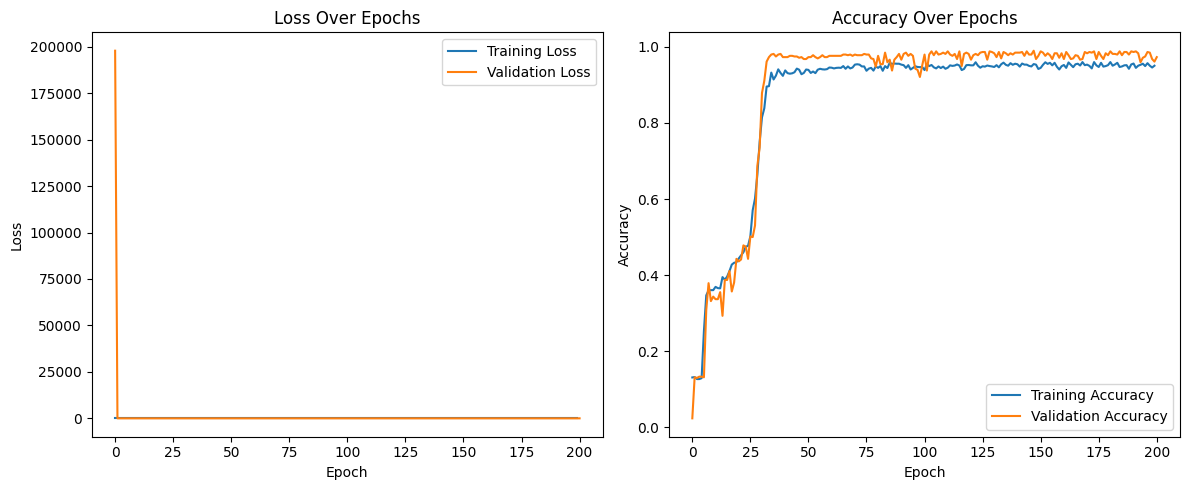

In [ ]:
history_callback.plot_history()

In [ ]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.9739
Precision: 0.9651
Recall: 0.9739
F1-Score: 0.9693

Confusion Matrix:
[[260   0   0   0]
 [  3  32   0   0]
 [  0   2   6   0]
 [  0   0   3   0]]

Classification Report:
              precision    recall  f1-score   support

         1.0       0.99      1.00      0.99       260
         2.0       0.94      0.91      0.93        35
         3.0       0.67      0.75      0.71         8
         4.0       0.00      0.00      0.00         3

    accuracy                           0.97       306
   macro avg       0.65      0.67      0.66       306
weighted avg       0.97      0.97      0.97       306



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

 # Normalizing effect on the models' accuracy

In [ ]:
# df_normalized = df_filtered[['real_memory_usage', 'layers', 'batch_size', 'all_parameters', 'all_activations']]/df_filtered[['real_memory_usage', 'layers', 'batch_size', 'all_parameters', 'all_activations']].mean()

# no normalization
# df_normalized = df


# columns_to_normalize = ['layers', 'batch_size', 'all_parameters', 'all_activations']

# from sklearn.preprocessing import StandardScaler
# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler and transform the data
# df_normalized = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)

# no normalization
df_normalized = df


# regression model

In [ ]:
columns_to_normalize = ['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
df_normalized_reg = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)

# no normalization
# df_normalized = df

In [ ]:
from sklearn.model_selection import train_test_split
x_train_reg, x_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    df_normalized_reg[['layers', 'batch_size', 'all_parameters', 'all_activations']].values, df_normalized_reg['real_memory_usage'].values, test_size=0.3, random_state=42)

x_test_reg, x_val_reg, y_test_reg, y_val_reg = train_test_split(
    x_temp_reg, y_temp_reg, test_size=0.66, random_state=42)

print('total data size: ', len(df_normalized))
print(f"train size {len(x_train_reg)}, val size: {len(x_val_reg)}, test size: {len(x_test_reg)}")

In [ ]:
train_dataloader_reg = DataLoader(CustomDataset(x_train_reg, y_train_reg), 64, num_workers=2, shuffle=True)
val_dataloader_reg = DataLoader(CustomDataset(x_val_reg, y_val_reg), 64, num_workers=2)
test_dataloader_reg = DataLoader(CustomDataset(x_test_reg, y_test_reg),1, num_workers=1)
x, y = next(iter(train_dataloader_reg))
print(f"input shape: {x.shape}, output shape: {y.shape}")

In [ ]:
class regression_gpu_usage(pl.LightningModule):
    def __init__(self):
        super(regression_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=4, output_features=1, base_features=4)
        # self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()
        # self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = Adam(self.parameters(), lr=0.0001)

        # # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         'monitor': 'val_loss',
        #         'frequency': 1
        #     }
        # }
        return optimizer



In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
# logger = TensorBoardLogger("logs")
# Create a checkpoint callback

# checkpoint_callback = ModelCheckpoint(
#     dirpath=config['model_save_dir'],
#     filename=f"{config['modality_type']}",
#     save_top_k=1,
#     verbose=True,
#     monitor='val_loss',
#     mode='min'
# )

# Initialize the model
regression_model = regression_gpu_usage()
regression_model.train()
# Initialize the trainer with mixed precision (AMP) and early stopping
trainer = pl.Trainer(
    # logger = logger,
    max_epochs=200,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(regression_model, train_dataloaders=train_dataloader_reg, val_dataloaders=val_dataloader_reg)



In [ ]:
regression_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader_reg:
        pred = regression_model(test_data[0])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(pred.item())
        print(f"prediction: {pred.item()}, gt: {test_data[1].item()}")

plt.figure(figsize=(15, 3))
plt.scatter(range(1, len(pred_list) + 1), pred_list, label="predicted")
plt.scatter(range(1, len(gt) + 1), gt, label="actual value")
plt.legend()